<a href="https://colab.research.google.com/github/banulaperera/METANO-Metal-Aware-InChI-to-IUPAC-Transformer-with-Neuro-Symbolic-Oversight/blob/model_dev/METANO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# METANO: Metal Aware InChI to IUPAC Transformer with Neuro Symbolic Oversight

## Project Overview
METANO is an AI-driven software platform designed to automatically translate International Chemical Identifier (InChI) strings, including challenging Reconnect InChI variants, into systematic IUPAC names. This implementation leverages:

- **Pre-trained T5 Transformer Model** for sequence-to-sequence translation
- **Neurosymbolic Validation** combining neural predictions with chemical rules
- **Comprehensive Accuracy Evaluation** with multiple metrics

### Key Features
- Handles both Standard InChI and Reconnected InChI formats  
- Optimized for organometallic and coordination compounds  
- Real-time chemical validation and error correction  
- Production-ready accuracy metrics and evaluation  

##  Setup and Installation
Install required dependencies and configure the environment

In [2]:
# Install required packages
!pip install RDKit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 26.7 MB/s eta 0:00:00


In [7]:
# Import core libraries
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
from tqdm.auto import tqdm
import re
import os
import json
import random
from dataclasses import dataclass, field
from typing import List, Tuple, Dict
import warnings
warnings.filterwarnings('ignore')
import logging
from datetime import datetime
from pathlib import Path
import tempfile

# Google drive intergration imports
try:
  from google.colab import drive, files, auth
  from googleapiclient.discovery import build
  from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload
  from io import BytesIO
  DRIVE_AVAILABLE = True
except:
  DRIVE_AVAILABLE = False

# Transformers and ML libraries
from transformers import (
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

# from sklearn.metrics import accuracy_score, precision_recall_fscore_support

try:
    import nltk
    nltk.download('punkt', quiet=True)
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
except ImportError:
    print(" NLTK not available - BLEU score calculation will be limited")

# Chemical libraries
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    print(" RDKit loaded successfully")
except ImportError:
    print(" RDKit not available - chemical validation will be limited")
    Chem = None

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('metano_training.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

 RDKit loaded successfully
 Using device: cpu


##  Configuration and Hyperparameters
Optimized configuration for production-level performance

In [4]:
@dataclass
class ModelConfig:
    """Optimized configuration for METANO model"""

    # Model parameters
    model_name: str = "t5-small"  # Pre-trained T5 model
    max_input_length: int = 512
    max_output_length: int = 256

    # Training hyperparameters (optimized)
    learning_rate: float = 3e-4
    weight_decay: float = 0.01
    warmup_ratio: float = 0.1
    num_epochs: int = 10
    batch_size: int = 4  # Reduced batch size to save memory
    gradient_accumulation_steps: int = 8 # Increased accumulation steps to compensate

    # Validation parameters
    eval_steps: int = 500
    save_steps: int = 1000
    early_stopping_patience: int = 3
    eval_strategy: str = "epochs"

    # Generation parameters
    num_beams: int = 4
    do_sample: bool = False
    temperature: float = 1.0
    top_k: int = 50

    # Neurosymbolic parameters
    enable_chemical_validation: bool = True
    enable_grammar_checking: bool = True
    enable_metal_coordination_validation: bool = True
    confidence_threshold: float = 0.5

    # Metal-specific parameters
    metal_elements: List[str] = field(default_factory=lambda: [
        'Li', 'Na', 'K', 'Rb', 'Cs', 'Be', 'Mg', 'Ca', 'Sr', 'Ba', 'Ra',
        'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
        'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd',
        'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg',
        'Al', 'Ga', 'In', 'Tl', 'Sn', 'Pb', 'Bi'
    ])

    # Data parameters
    train_split: float = 0.8
    val_split: float = 0.1
    test_split: float = 0.1

    # Directory paths
    output_dir: str = "./metano_model"
    cache_dir: str = "./cache"
    logs_dir: str = "./logs"

    # Google Drive checkpoint parameters
    use_google_drive: bool = DRIVE_AVAILABLE
    gdrive_checkpoint_folder: str = "METANO_Checkpoints"
    checkpoint_frequency: int = 1  # Save every N epochs
    max_checkpoints: int = 5  # Keep only N recent checkpoints
    auto_resume: bool = True
    backup_to_local: bool = True

    # Experiment tracking
    experiment_name: str = "metano_inchi2iupac"
    run_name: str = field(default_factory=lambda: f"run_{datetime.now().strftime('%Y%m%d_%H%M%S')}")

    def __post_init__(self):
        """Create necessary directories"""
        for directory in [self.output_dir, self.cache_dir, self.logs_dir]:
            Path(directory).mkdir(parents=True, exist_ok=True)

# Initialize configuration
config = ModelConfig()
print(" Configuration loaded:")
print(f"   Model: {config.model_name}")
print(f"   Learning rate: {config.learning_rate}")
print(f"   Batch size: {config.batch_size}")
print(f"   Max epochs: {config.num_epochs}")
print(f"   Device: {device}")

 Configuration loaded:
   Model: t5-small
   Learning rate: 0.0003
   Batch size: 4
   Max epochs: 10
   Device: cpu


## Creating Checkpoints
Checkpoint management with local and cloud synchronization

In [8]:
class GoogleDriveManager:
    """Google Drive integration for model checkpoints"""

    def __init__(self, config: ModelConfig):
        self.config = config
        self.service = None
        self.folder_id = None
        self.authenticated = False

        if config.use_google_drive and DRIVE_AVAILABLE:
            self.authenticate()
            if self.authenticated:
                self.setup_checkpoint_folder()

    def authenticate(self):
        """Authenticate with Google Drive API"""
        try:
            if DRIVE_AVAILABLE:
                auth.authenticate_user()
                self.service = build('drive', 'v3')
                self.authenticated = True
                logger.info(" Google Drive authentication successful")
            else:
                logger.warning(" Google Colab not available - skipping Drive authentication")
        except Exception as e:
            logger.error(f" Google Drive authentication failed: {e}")
            self.config.use_google_drive = False

    def setup_checkpoint_folder(self):
        """Create or locate the checkpoint folder in Google Drive"""
        if not self.authenticated:
            return

        try:
            # Search for existing folder
            query = f"name='{self.config.gdrive_checkpoint_folder}' and mimeType='application/vnd.google-apps.folder' and trashed=false"
            results = self.service.files().list(
                q=query,
                fields="files(id, name, createdTime)"
            ).execute()

            folders = results.get('files', [])

            if folders:
                self.folder_id = folders[0]['id']
                logger.info(f" Found existing checkpoint folder: {self.config.gdrive_checkpoint_folder}")
            else:
                # Create new folder
                folder_metadata = {
                    'name': self.config.gdrive_checkpoint_folder,
                    'mimeType': 'application/vnd.google-apps.folder'
                }
                folder = self.service.files().create(
                    body=folder_metadata,
                    fields='id'
                ).execute()
                self.folder_id = folder['id']
                logger.info(f" Created new checkpoint folder: {self.config.gdrive_checkpoint_folder}")

        except Exception as e:
            logger.error(f" Failed to setup checkpoint folder: {e}")
            self.config.use_google_drive = False

    def save_checkpoint(self, checkpoint_data: Dict, epoch: int, loss: float, metrics: Dict = None):
        """Save checkpoint to Google Drive with comprehensive metadata"""
        if not self.authenticated or not self.folder_id:
            logger.warning(" Google Drive not available - skipping cloud backup")
            return None

        try:
            # Create detailed checkpoint filename
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            metrics_str = ""
            if metrics and 'val_loss' in metrics:
                metrics_str = f"_val{metrics['val_loss']:.4f}"

            filename = f"metano_checkpoint_e{epoch:03d}_loss{loss:.4f}{metrics_str}_{timestamp}.pt"

            # Save checkpoint to temporary file
            temp_path = os.path.join(tempfile.gettempdir(), filename)

            # Add metadata to checkpoint
            enhanced_checkpoint = {
                **checkpoint_data,
                'save_timestamp': timestamp,
                'metrics': metrics or {},
                'config_snapshot': self.config.__dict__.copy(),
                'device_info': str(device),
                'torch_version': torch.__version__
            }

            torch.save(enhanced_checkpoint, temp_path)

            # Upload to Google Drive
            file_metadata = {
                'name': filename,
                'parents': [self.folder_id],
                'description': f"METANO checkpoint - Epoch {epoch}, Loss {loss:.4f}"
            }

            media = MediaFileUpload(temp_path, resumable=True)
            upload_request = self.service.files().create(
                body=file_metadata,
                media_body=media,
                fields='id,name,size'
            )

            # Execute upload with progress tracking
            response = None
            while response is None:
                status, response = upload_request.next_chunk()
                if status:
                    progress = int(status.progress() * 100)
                    if progress % 25 == 0:  # Log every 25% progress
                        logger.info(f" Upload progress: {progress}%")

            # Clean up local temp file
            os.remove(temp_path)

            logger.info(f" Checkpoint uploaded to Google Drive: {filename}")
            logger.info(f" File size: {int(response.get('size', 0)) / (1024*1024):.1f} MB")

            # Clean up old checkpoints
            self.cleanup_old_checkpoints()

            return response['id']

        except Exception as e:
            logger.error(f" Failed to save checkpoint to Google Drive: {e}")
            return None

    def list_checkpoints(self) -> List[Dict]:
        """List all checkpoints in Google Drive folder with detailed metadata"""
        if not self.authenticated or not self.folder_id:
            return []

        try:
            query = f"'{self.folder_id}' in parents and name contains 'metano_checkpoint' and trashed=false"
            results = self.service.files().list(
                q=query,
                fields="files(id, name, createdTime, modifiedTime, size, description)",
                orderBy="createdTime desc",
                pageSize=50
            ).execute()

            checkpoints = results.get('files', [])

            # Parse metadata from filenames
            for checkpoint in checkpoints:
                filename = checkpoint['name']
                # Extract epoch using regex
                epoch_match = re.search(r'_e(\d+)_', filename)
                loss_match = re.search(r'_loss([\d\.]+)', filename)
                val_loss_match = re.search(r'_val([\d\.]+)', filename)

                checkpoint['parsed_epoch'] = int(epoch_match.group(1)) if epoch_match else 0
                checkpoint['parsed_loss'] = float(loss_match.group(1)) if loss_match else float('inf')
                checkpoint['parsed_val_loss'] = float(val_loss_match.group(1)) if val_loss_match else None
                checkpoint['size_mb'] = int(checkpoint.get('size', 0)) / (1024*1024) if checkpoint.get('size') else 0

            return checkpoints

        except Exception as e:
            logger.error(f" Failed to list checkpoints: {e}")
            return []

    def load_checkpoint(self, checkpoint_id: str = None) -> Dict:
        """Load checkpoint from Google Drive with enhanced error handling"""
        if not self.authenticated:
            logger.warning(" Google Drive not authenticated")
            return None

        try:
            # If no specific checkpoint ID, get the latest
            if checkpoint_id is None:
                checkpoints = self.list_checkpoints()
                if not checkpoints:
                    logger.info(" No checkpoints found in Google Drive")
                    return None
                checkpoint_id = checkpoints[0]['id']  # Latest checkpoint
                logger.info(f" Loading latest checkpoint: {checkpoints[0]['name']}")

            # Download checkpoint with progress tracking
            request = self.service.files().get_media(fileId=checkpoint_id)
            file_io = BytesIO()
            downloader = MediaIoBaseDownload(file_io, request)

            done = False
            while done is False:
                status, done = downloader.next_chunk()
                if status:
                    progress = int(status.progress() * 100)
                    if progress % 25 == 0:
                        logger.info(f" Download progress: {progress}%")

            # Load checkpoint data
            file_io.seek(0)
            checkpoint_data = torch.load(file_io, map_location=device)

            logger.info(" Checkpoint loaded successfully from Google Drive")
            logger.info(f" Checkpoint epoch: {checkpoint_data.get('epoch', 'unknown')}")
            logger.info(f" Checkpoint loss: {checkpoint_data.get('loss', 'unknown')}")

            return checkpoint_data

        except Exception as e:
            logger.error(f" Failed to load checkpoint from Google Drive: {e}")
            return None

    def cleanup_old_checkpoints(self):
        """Remove old checkpoints beyond max_checkpoints limit"""
        if not self.authenticated:
            return

        try:
            checkpoints = self.list_checkpoints()

            if len(checkpoints) > self.config.max_checkpoints:
                # Sort by creation time and keep only the most recent
                checkpoints_to_delete = checkpoints[self.config.max_checkpoints:]

                for checkpoint in checkpoints_to_delete:
                    self.service.files().delete(fileId=checkpoint['id']).execute()
                    logger.info(f" Deleted old checkpoint: {checkpoint['name']}")

                logger.info(f" Cleaned up {len(checkpoints_to_delete)} old checkpoints")

        except Exception as e:
            logger.error(f" Failed to cleanup old checkpoints: {e}")

    def get_checkpoint_summary(self) -> Dict:
        """Get comprehensive summary of all checkpoints"""
        checkpoints = self.list_checkpoints()

        if not checkpoints:
            return {'total_checkpoints': 0, 'latest_checkpoint': None}

        # Calculate summary statistics
        total_size_mb = sum(cp.get('size_mb', 0) for cp in checkpoints)
        epochs = [cp['parsed_epoch'] for cp in checkpoints if cp['parsed_epoch'] > 0]
        losses = [cp['parsed_loss'] for cp in checkpoints if cp['parsed_loss'] < float('inf')]

        latest = checkpoints[0]

        return {
            'total_checkpoints': len(checkpoints),
            'total_size_mb': total_size_mb,
            'latest_checkpoint': {
                'name': latest['name'],
                'epoch': latest['parsed_epoch'],
                'loss': latest['parsed_loss'],
                'created_time': latest['createdTime'],
                'size_mb': latest['size_mb']
            },
            'epoch_range': (min(epochs), max(epochs)) if epochs else (0, 0),
            'loss_range': (min(losses), max(losses)) if losses else (0, 0),
            'avg_checkpoint_size_mb': total_size_mb / len(checkpoints) if checkpoints else 0
        }

In [9]:
class CheckpointManager:
    """Advanced checkpoint management with local and cloud synchronization"""

    def __init__(self, config: ModelConfig):
        self.config = config
        self.gdrive_manager = GoogleDriveManager(config) if config.use_google_drive else None
        self.local_checkpoint_dir = Path(config.output_dir) / "checkpoints"
        self.local_checkpoint_dir.mkdir(parents=True, exist_ok=True)

        # Initialize checkpoint metadata
        self.checkpoint_history = []
        self.load_checkpoint_history()

    def save_checkpoint(self, model, optimizer, scheduler, epoch: int, loss: float,
                       metrics: Dict = None, is_best: bool = False) -> str:
        """Save checkpoint with comprehensive metadata tracking"""

        # Prepare checkpoint data
        checkpoint_data = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'epoch': epoch,
            'loss': loss,
            'metrics': metrics or {},
            'config': self.config.__dict__.copy(),
            'timestamp': datetime.now().isoformat(),
            'device': str(device),
            'is_best': is_best,
            'torch_version': torch.__version__,
            'model_parameters': sum(p.numel() for p in model.parameters())
        }

        # Generate checkpoint filename
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"checkpoint_e{epoch:03d}_loss{loss:.4f}_{timestamp}.pt"

        # Save locally
        local_path = self.local_checkpoint_dir / filename
        torch.save(checkpoint_data, local_path)

        # Update checkpoint history
        checkpoint_info = {
            'epoch': epoch,
            'loss': loss,
            'metrics': metrics or {},
            'filename': filename,
            'local_path': str(local_path),
            'timestamp': checkpoint_data['timestamp'],
            'is_best': is_best,
            'file_size_mb': local_path.stat().st_size / (1024*1024)
        }

        self.checkpoint_history.append(checkpoint_info)
        self.save_checkpoint_history()

        logger.info(f" Local checkpoint saved: {filename}")
        logger.info(f" File size: {checkpoint_info['file_size_mb']:.1f} MB")

        # Save best model separately
        if is_best:
            best_path = Path(self.config.output_dir) / "best_model.pt"
            torch.save(checkpoint_data, best_path)
            logger.info(" Best model checkpoint saved")

        # Save to Google Drive if enabled and conditions met
        gdrive_id = None
        if (self.gdrive_manager and
            (epoch % self.config.checkpoint_frequency == 0 or is_best)):
            gdrive_id = self.gdrive_manager.save_checkpoint(checkpoint_data, epoch, loss, metrics)
            if gdrive_id:
                checkpoint_info['gdrive_id'] = gdrive_id

        # Cleanup old local checkpoints
        self.cleanup_local_checkpoints()

        return str(local_path)

    def load_checkpoint(self, checkpoint_path: str = None, from_gdrive: bool = False,
                       epoch: int = None) -> Dict:
        """Advanced checkpoint loading with multiple fallback options"""

        # Priority order: specific path -> Google Drive -> latest local
        checkpoint_data = None

        # Option 1: Load specific checkpoint path
        if checkpoint_path and Path(checkpoint_path).exists():
            checkpoint_data = torch.load(checkpoint_path, map_location=device)
            logger.info(f" Checkpoint loaded from specified path: {checkpoint_path}")
            return checkpoint_data

        # Option 2: Load from Google Drive
        if from_gdrive or (checkpoint_path is None and self.config.auto_resume and self.gdrive_manager):
            checkpoint_data = self.gdrive_manager.load_checkpoint()
            if checkpoint_data:
                return checkpoint_data

        # Option 3: Load specific epoch from local
        if epoch is not None:
            matching_checkpoints = [
                cp for cp in self.checkpoint_history
                if cp['epoch'] == epoch and Path(cp['local_path']).exists()
            ]
            if matching_checkpoints:
                latest_match = max(matching_checkpoints, key=lambda x: x['timestamp'])
                checkpoint_data = torch.load(latest_match['local_path'], map_location=device)
                logger.info(f" Epoch {epoch} checkpoint loaded: {latest_match['filename']}")
                return checkpoint_data

        # Option 4: Load latest local checkpoint
        if self.checkpoint_history:
            # Sort by timestamp and get the latest
            sorted_checkpoints = sorted(
                self.checkpoint_history,
                key=lambda x: x['timestamp'],
                reverse=True
            )

            for checkpoint_info in sorted_checkpoints:
                local_path = Path(checkpoint_info['local_path'])
                if local_path.exists():
                    checkpoint_data = torch.load(local_path, map_location=device)
                    logger.info(f" Latest local checkpoint loaded: {checkpoint_info['filename']}")
                    return checkpoint_data

        logger.info(" No checkpoints found")
        return None

    def load_checkpoint_history(self):
        """Load checkpoint history from metadata file"""
        history_file = self.local_checkpoint_dir / "checkpoint_history.json"
        if history_file.exists():
            try:
                with open(history_file, 'r') as f:
                    self.checkpoint_history = json.load(f)
                logger.info(f" Loaded checkpoint history: {len(self.checkpoint_history)} entries")
            except Exception as e:
                logger.warning(f" Failed to load checkpoint history: {e}")
                self.checkpoint_history = []

    def save_checkpoint_history(self):
        """Save checkpoint history to metadata file"""
        history_file = self.local_checkpoint_dir / "checkpoint_history.json"
        try:
            with open(history_file, 'w') as f:
                json.dump(self.checkpoint_history, f, indent=2)
        except Exception as e:
            logger.warning(f" Failed to save checkpoint history: {e}")

    def cleanup_local_checkpoints(self):
        """Clean up old local checkpoints based on retention policy"""
        if len(self.checkpoint_history) <= self.config.max_checkpoints:
            return

        # Sort by timestamp and keep only recent ones (excluding best models)
        non_best_checkpoints = [cp for cp in self.checkpoint_history if not cp['is_best']]

        if len(non_best_checkpoints) > self.config.max_checkpoints:
            sorted_checkpoints = sorted(non_best_checkpoints, key=lambda x: x['timestamp'])
            checkpoints_to_remove = sorted_checkpoints[:-self.config.max_checkpoints]

            for checkpoint_info in checkpoints_to_remove:
                local_path = Path(checkpoint_info['local_path'])
                if local_path.exists():
                    local_path.unlink()
                    logger.info(f" Removed old local checkpoint: {checkpoint_info['filename']}")

                # Remove from history
                self.checkpoint_history.remove(checkpoint_info)

            self.save_checkpoint_history()

    def get_checkpoint_summary(self) -> Dict:
        """Get comprehensive summary of checkpoint status"""
        local_summary = {
            'total_local_checkpoints': len(self.checkpoint_history),
            'best_checkpoints': len([cp for cp in self.checkpoint_history if cp['is_best']]),
            'total_size_mb': sum(cp.get('file_size_mb', 0) for cp in self.checkpoint_history),
            'epoch_range': None,
            'latest_checkpoint': None
        }

        if self.checkpoint_history:
            epochs = [cp['epoch'] for cp in self.checkpoint_history]
            local_summary['epoch_range'] = (min(epochs), max(epochs))
            local_summary['latest_checkpoint'] = max(
                self.checkpoint_history, key=lambda x: x['timestamp']
            )

        # Get Google Drive summary if available
        gdrive_summary = {}
        if self.gdrive_manager:
            gdrive_summary = self.gdrive_manager.get_checkpoint_summary()

        return {
            'local': local_summary,
            'google_drive': gdrive_summary,
            'sync_enabled': self.config.use_google_drive and self.gdrive_manager is not None
        }

##  Data Loading and Preprocessing
Load and preprocess the InChI-IUPAC dataset with robust validation

In [ ]:
class InChIDatasetLoader:
    """Enhanced dataset loader with chemical validation"""

    def __init__(self, config: ModelConfig):
        self.config = config
        self.metal_elements = [
            'Li', 'Na', 'K', 'Rb', 'Cs', 'Be', 'Mg', 'Ca', 'Sr', 'Ba', 'Ra',
            'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
            'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd',
            'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg',
            'Al', 'Ga', 'In', 'Tl', 'Sn', 'Pb', 'Bi'
        ]

    def create_sample_dataset(self) -> List[Tuple[str, str]]:
        """Create a sample dataset for demonstration"""
        sample_data = [
            # Organic compounds
            ("InChI=1S/CH4/h1H4", "methane"),
            ("InChI=1S/C2H6/c1-2/h1-2H3", "ethane"),
            ("InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3", "ethanol"),
            ("InChI=1S/C6H6/c1-2-4-6-5-3-1/h1-6H", "benzene"),
            ("InChI=1S/C7H8/c1-7-5-3-2-4-6-7/h2-6H,1H3", "toluene"),
            ("InChI=1S/C8H10/c1-3-7-5-4-6-8(2)9-7/h4-6H,3H2,1-2H3", "ethylbenzene"),

            # Organometallic compounds (reconnected InChI)
            ("InChI=1/2C5H5.Fe/c2*1-2-4-5-3-1;/h2*1-5H;/rC10H10Fe/c1-2-4-8-6(1)11-7-3-1-5-9(7)10(11)12-8/h1-10H",
             "bis(η⁵-cyclopentadienyl)iron"),
            ("InChI=1/4CO.Co/c4*1-2;/rC4CoO4/c6-1-5(2-7,3-8)4-9/o1-2,2-3,3-4,4-1",
             "tetracarbonylcobalt(0)"),
            ("InChI=1/6CO.Cr/c6*1-2;/rC6CrO6/c7-1-8(2-9,3-10,4-11,5-12)6-13",
             "hexacarbonylchromium(0)"),
            ("InChI=1/4C18H15P.Ni/c4*1-4-10-16(11-5-1)19(17-12-6-2-7-13-17)18-14-8-3-9-15-18;/h4*1-15H;",
             "tetrakis(triphenylphosphine)nickel(0)"),

            # Complex organics
            ("InChI=1S/C9H8O/c10-8-7-9-5-3-1-2-4-6-9/h1-8H", "benzaldehyde"),
            ("InChI=1S/C7H6O2/c8-6-7-4-2-1-3-5-7-9/h1-5H,(H,8,9)", "benzoic acid"),
            ("InChI=1S/C6H12O6/c7-1-2-3(8)4(9)5(10)6(11)12-2/h2-11H,1H2/t2-,3-,4+,5-,6+/m1/s1",
             "α-D-glucopyranose"),

            # Coordination compounds
            ("InChI=1/6H3N.Co.3ClH/h6*1H3;;3*1H/q;;3*-1;+3", "hexaamminecobalt(III) chloride"),
            ("InChI=1/2C10H8N2.Fe/c2*1-3-9-5-6-10-4-2-8-12-11-9;/h2*1-8H;",
             "bis(2,2'-bipyridine)iron(II)"),

            # More organometallics
            ("InChI=1/C8H8.Fe/c1-2-4-6-8-7-5-3-1;/h1-8H;", "(η⁸-cyclooctatetraene)iron"),
        ]

        # Expand dataset with variations
        expanded_data = sample_data * 50  # Duplicate for training
        random.shuffle(expanded_data)

        return expanded_data

    def load_from_file(self, file_path: str) -> List[Tuple[str, str]]:
        """Load dataset from tab-separated file"""
        data = []

        if not os.path.exists(file_path):
            print(f" File not found: {file_path}")
            print(" Creating sample dataset for demonstration...")
            return self.create_sample_dataset()

        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()

            print(f" Loading dataset from {file_path}")
            valid_count = 0
            invalid_count = 0

            for line_num, line in enumerate(tqdm(lines, desc="Processing lines"), 1):
                line = line.strip()
                if not line or line.startswith('#'):
                    continue

                try:
                    parts = line.split('\t')
                    if len(parts) >= 2:
                        inchi = parts[0].strip()
                        iupac = parts[1].strip()

                        if self._validate_pair(inchi, iupac):
                            data.append((inchi, iupac))
                            valid_count += 1
                        else:
                            invalid_count += 1
                except Exception as e:
                    invalid_count += 1
                    continue

            print(f" Loaded {valid_count} valid pairs")
            print(f" Filtered {invalid_count} invalid pairs")

        except Exception as e:
            print(f" Error loading file: {e}")
            print(" Using sample dataset instead...")
            return self.create_sample_dataset()

        return data if data else self.create_sample_dataset()

    def _validate_pair(self, inchi: str, iupac: str) -> bool:
        """Validate InChI-IUPAC pair"""
        # Basic format checks
        if not inchi or not iupac:
            return False

        if not inchi.startswith('InChI='):
            return False

        if len(inchi) < 10 or len(iupac) < 2:
            return False

        # Check for invalid IUPAC names
        invalid_names = ['unknown', 'error', 'invalid', 'n/a', 'none']
        if iupac.lower().strip() in invalid_names:
            return False

        return True

    def analyze_dataset(self, data: List[Tuple[str, str]]) -> Dict:
        """Analyze dataset composition"""
        analysis = {
            'total_pairs': len(data),
            'inchi_formats': {'standard': 0, 'reconnected': 0, 'unknown': 0},
            'has_metals': 0,
            'avg_inchi_length': 0,
            'avg_iupac_length': 0,
            'metal_distribution': {},
            'sample_pairs': []
        }

        inchi_lengths = []
        iupac_lengths = []

        for i, (inchi, iupac) in enumerate(data):
            inchi_lengths.append(len(inchi))
            iupac_lengths.append(len(iupac))

            # Format analysis
            if 'InChI=1S/' in inchi:
                analysis['inchi_formats']['standard'] += 1
            elif '/r' in inchi:
                analysis['inchi_formats']['reconnected'] += 1
            else:
                analysis['inchi_formats']['unknown'] += 1

            # Metal analysis
            metals_found = [m for m in self.metal_elements if m in inchi]
            if metals_found:
                analysis['has_metals'] += 1
                for metal in metals_found:
                    analysis['metal_distribution'][metal] = analysis['metal_distribution'].get(metal, 0) + 1

            # Sample pairs
            if i < 3:
                analysis['sample_pairs'].append({
                    'inchi': inchi[:60] + '...' if len(inchi) > 60 else inchi,
                    'iupac': iupac
                })

        analysis['avg_inchi_length'] = np.mean(inchi_lengths) if inchi_lengths else 0
        analysis['avg_iupac_length'] = np.mean(iupac_lengths) if iupac_lengths else 0

        return analysis

# Load and analyze dataset
print("📊 Loading InChI-IUPAC dataset...")
loader = InChIDatasetLoader(config)

# Try to load from file or create sample data
dataset_path = "/content/InorganicReconnectedNames.txt"  # Replace with your actual dataset path
data = loader.load_from_file(dataset_path)

# Analyze dataset
analysis = loader.analyze_dataset(data)
print(f"\n Dataset Analysis:")
print(f"   Total pairs: {analysis['total_pairs']}")
print(f"   InChI formats: {analysis['inchi_formats']}")
print(f"   Contains metals: {analysis['has_metals']}")
print(f"   Avg InChI length: {analysis['avg_inchi_length']:.1f}")
print(f"   Avg IUPAC length: {analysis['avg_iupac_length']:.1f}")

if analysis['metal_distribution']:
    top_metals = dict(sorted(analysis['metal_distribution'].items(), key=lambda x: x[1], reverse=True)[:5])
    print(f"   Top metals: {top_metals}")

print(f"\n Sample pairs:")
for i, sample in enumerate(analysis['sample_pairs']):
    print(f"   {i+1}. InChI: {sample['inchi']}")
    print(f"      IUPAC: {sample['iupac']}")

📊 Loading InChI-IUPAC dataset...
 File not found: /content/InorganicReconnectedNames.txt
 Creating sample dataset for demonstration...

 Dataset Analysis:
   Total pairs: 800
   InChI formats: {'standard': 450, 'reconnected': 150, 'unknown': 200}
   Contains metals: 800
   Avg InChI length: 51.9
   Avg IUPAC length: 17.6
   Top metals: {'In': 800, 'Fe': 150, 'Co': 100, 'Ni': 50, 'Cr': 50}

 Sample pairs:
   1. InChI: InChI=1S/C6H12O6/c7-1-2-3(8)4(9)5(10)6(11)12-2/h2-11H,1H2/t2...
      IUPAC: α-D-glucopyranose
   2. InChI: InChI=1S/C6H12O6/c7-1-2-3(8)4(9)5(10)6(11)12-2/h2-11H,1H2/t2...
      IUPAC: α-D-glucopyranose
   3. InChI: InChI=1S/C8H10/c1-3-7-5-4-6-8(2)9-7/h4-6H,3H2,1-2H3
      IUPAC: ethylbenzene


##  Neurosymbolic Validation System
Implement chemical rule-based validation and correction

In [ ]:
class ChemicalValidator:
    """Neurosymbolic chemical validation system"""

    def __init__(self, config: ModelConfig):
      self.config = config

      # Chemical grammar rules
      self.grammar_rules = {
          'required_patterns': [
              r'^[a-zA-Z]',  # Must start with letter
              r'[a-zA-Z0-9]$'  # Must end with alphanumeric
          ],
          'forbidden_patterns': [
              r'--',  # Double dashes
              r',,',  # Double commas
              r'\(\)',  # Empty parentheses
              r'\[\]',  # Empty brackets
              r'  ',  # Double spaces
          ],
          'valid_chars': set('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
                            '()[]{},-+⁰¹²³⁴⁵⁶⁷⁸⁹⁺⁻₀₁₂₃₄₅₆₇₈₉ηκμλΔΛ ')
      }

      # Stereochemistry validation
      self.stereo_patterns = {
            'chirality': [r'\([RS]\)', r'\(R\)', r'\(S\)', r'\(\d+[RS]\)', r'\(\d+R\)', r'\(\d+S\)'],
            'geometry': [r'\([EZ]\)', r'\(E\)', r'\(Z\)'],
            'coordination': [r'fac-', r'mer-', r'cis-', r'trans-', r'Δ', r'Λ'],
            'haptic': [r'η[1-8]', r'η⁵', r'η⁶', r'η¹', r'η²', r'η³', r'η⁴', r'η⁷', r'η⁸']
        }

      # Metal nomenclature patterns
      self.metal_nomenclature = {
            'Fe': [
                r'\biron\b', r'\bferr\w*', r'\bferrocene\b',
                r'bis\([^)]*cyclopentadienyl[^)]*\)iron',
                r'cyclopentadienyl.*iron', r'iron.*cyclopentadienyl'
            ],
            'Co': [r'\bcobalt\b', r'\bcob\w*'],
            'Ni': [r'\bnickel\b', r'\bnick\w*'],
            'Cu': [r'\bcopper\b', r'\bcupr\w*', r'\bcupro\w*'],
            'Zn': [r'\bzinc\b'],
            'Mn': [r'\bmanganese\b', r'\bmangan\w*'],
            'Cr': [r'\bchromium\b', r'\bchrom\w*'],
            'Ti': [r'\btitanium\b', r'\btitan\w*'],
            'Pt': [r'\bplatinum\b', r'\bplatin\w*'],
            'Pd': [r'\bpalladium\b', r'\bpallad\w*'],
            'Au': [r'\bgold\b', r'\baur\w*'],
            'Ag': [r'\bsilver\b', r'\bargent\w*'],
            'V': [r'\bvanadium\b', r'\bvanad\w*'],
            'W': [r'\btungsten\b', r'\bwolfram\w*'],
            'Mo': [r'\bmolybdenum\b', r'\bmolybden\w*'],
            'Ru': [r'\bruthenium\b', r'\bruthen\w*'],
            'Rh': [r'\brhodium\b', r'\brhod\w*'],
            'Os': [r'\bosmium\b', r'\bosm\w*'],
            'Ir': [r'\biridium\b', r'\birid\w*']
        }

      print(" Chemical Validator initialized")

    def validate_prediction(self, inchi: str, predicted_iupac: str, attention_weights: Optional[np.ndarray] = None) -> Dict:
      """Comprehensive validation of predicted IUPAC name"""
      validation_result = {
          'is_valid': True,
          'confidence': 1.0,
          'errors': [],
          'warnings': [],
          'scores': {},
          'detailed_analysis': {}
      }

      # Grammar validation
      grammar_score = self._validate_grammar(predicted_iupac)
      validation_result['scores']['grammar'] = grammar_score
      if grammar_score < 0.5:
          validation_result['is_valid'] = False
          validation_result['errors'].append(f"Grammar score: {grammar_score:.3f}")

      # Metal coordination validation
      metal_score = self._validate_metal_coordination(inchi, predicted_iupac)
      validation_result['scores']['metal_coordination'] = metal_score

      # Stereochemistry validation
      stereo_score = self._validate_stereochemistry(inchi, predicted_iupac)
      validation_result['scores']['stereochemistry'] = stereo_score

      # Chemical structure validation (if RDKit available)
      structure_score = self._validate_chemical_structure(inchi)
      validation_result['scores']['structure_consistency'] = structure_score

      # IUPAC nomenclature rules
      nomenclature_score = self._validate_iupac_nomenclature(predicted_iupac, inchi)
      validation_result['scores']['nomenclature'] = nomenclature_score

      # Attention-based validation (if available)
      if attention_weights is not None:
          attention_score = self._validate_attention_patterns(attention_weights)
          validation_result['scores']['attention_quality'] = attention_score
      else:
          validation_result['scores']['attention_quality'] = 0.8 # Neutral if not available

      # Aggregate scores
      scores = validation_result['scores']
      # Adaptive weighting based on compound type
      if self._is_organometallic_compound(inchi, predicted_iupac):
          weights = {
              'grammar': 0.15,
              'metal_coordination': 0.35,  # Higher for organometallics
              'stereochemistry': 0.10,
              'structure_consistency': 0.25,
              'nomenclature': 0.10,
              'attention_quality': 0.05
          }
      else:
          weights = {
              'grammar': 0.25,
              'metal_coordination': 0.10,  # Lower for organic compounds
              'stereochemistry': 0.20,
              'structure_consistency': 0.25,
              'nomenclature': 0.15,
              'attention_quality': 0.05
          }

      weighted_score = sum(scores.get(key, 0) * weight
                           for key, weight in weights.items())
      validation_result['confidence'] = weighted_score

      # Determine validity
      if weighted_score < self.config.confidence_threshold:
          validation_result['is_valid'] = False
          validation_result['errors'].append(f"Low confidence score: {weighted_score:.3f}")

      # Add detailed analysis
      validation_result['detailed_analysis'] = self._generate_detailed_analysis(
          inchi, predicted_iupac, validation_result
      )

      return validation_result

    def _validate_grammar(self, iupac: str) -> float:
      """Validate IUPAC grammar with chemical specific rules"""
      score = 1.0

      # Character validation
      invalid_chars = set(iupac) - self.grammar_rules['valid_chars']
      if invalid_chars:
        score *= 0.3

      # Pattern validation
      for pattern in self.grammar_rules['forbidden_patterns']:
          if re.search(pattern, iupac):
              score *= 0.4

      for pattern in self.grammar_rules['required_patterns']:
          if not re.search(pattern, iupac):
              score *= 0.5

      # Length validation
      if len(iupac.strip()) < 2:
        score *= 0.1
      # If the name is very long, it can be a malformed name
      elif len(iupac.strip()) > 200:
        score *= 0.8

      # Parenthese/bracket balance
      if not self._check_bracket_balance(iupac):
        score *= 0.4

      return max(0.0, min(1.0, score))

    def _check_bracket_balance(self, text: str) -> bool:
      """Check if parentheses and brackets are balanced"""
      stack = []
      pairs = {'(':')', '[':']', '{':'}'}

      for char in text:
          if char in pairs:
              stack.append(char)
          elif char in pairs.values():
              if not stack or pairs[stack.pop()] != char:
                  return False

      return len(stack) == 0

    def _is_organometallic_compound(self, inchi: str, iupac: str) -> bool:
      """Determine if compound is organometallic"""
      # Check for metals in InChI
      has_metals = any(metal in inchi for metal in getattr(self.config, 'metal_elements', []))

      # Check for organometallic indicators in IUPAC
      organometallic_indicators = [
          'η', 'cyclopentadienyl', 'carbonyl', 'ferrocene', 'metallocene',
          'bis(', 'tris(', 'tetrakis(', 'coordination', 'complex'
      ]
      has_organometallic_terms = any(indicator in iupac.lower() for indicator in organometallic_indicators)

      # Check for reconnection layer (coordination compounds)
      has_coordination = '/r' in inchi

      return has_metals and (has_organometallic_terms or has_coordination)


    def _validate_metal_coordination(self, inchi: str, iupac: str) -> float:
      """Validate metal coordination consistency"""

      score = 1.0

      # Extract metal from InChI
      inchi_metals = []
      metal_elements = getattr(self.config, 'metal_elements', [
          'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Mn', 'Cr', 'Ti', 'V',
          'Pt', 'Pd', 'Au', 'Ag', 'Mo', 'W', 'Ru', 'Rh', 'Os', 'Ir'
      ])

      for metal in metal_elements:
        if metal in inchi:
          inchi_metals.append(metal)

      # Check for metal names in IUPAC
      iupac_metals = []
      iupac_lower = iupac.lower()

      for metal, patterns in self.metal_nomenclature.items():
        for pattern in patterns:
          if re.search(pattern, iupac_lower):
            iupac_metals.append(metal)
            break # If metal found then move to next

      # If no metals in either, perfect score
      if not inchi_metals and not iupac_metals:
        return 1.0

      # If metals only in one source, check if it's a known exception
      if not inchi_metals or not iupac_metals:
        # Special case: some organomettallic names don;t explicitly metion the metal
        if 'ferrocene' in iupac_lower and 'Fe' in inchi_metals:
          return 0.9 # Good but not perfect
        return 0.3 # mismatch penalty

      common_metals = set(inchi_metals) & set(iupac_metals)
      total_metals = set(inchi_metals) | set(iupac_metals)

      if total_metals:
        metal_overlap = len(common_metals) / len(total_metals)
        score = metal_overlap
      else:
        score = 1.0

      # Check coordination number consistency
      if '/r' in inchi: # Reconnected InChI indicates coordination
        coordination_indicators = ['bis', 'tris', 'tetrakis', 'pentakis', 'hexakis',
                'η', 'cyclopentadienyl', 'carbonyl', 'complex']
        has_coordination_language = any(indicator in iupac_lower
                                        for indicator in coordination_indicators)
        if has_coordination_language:
          score = min(1.0, score + 0.2)
        else:
          score *= 0.7 # Penalty for missing coordination language

      return max(0.0, min(1.0, score))

    def _validate_stereochemistry(self, inchi: str, iupac: str) -> float:
      """Validate stereochemistry consistency"""
      score = 1.0

      # Check for stereochemistry in InChI
      has_inchi_stereo = bool(re.search(r'/[tms]', inchi))

      # Check for stereochemistry in IUPAC
      has_iupac_stereo = any(
          any(re.search(pattern, iupac, re.IGNORECASE) for pattern in patterns)
          for patterns in self.stereo_patterns.values()
      )

      # Consistency check
      if has_inchi_stereo and has_iupac_stereo:
          score = 1.0  # Perfect match
      elif not has_inchi_stereo and not has_iupac_stereo:
          score = 1.0  # Perfect match (no stereochemistry)
      elif has_inchi_stereo and not has_iupac_stereo:
          score = 0.7  # Missing stereochemistry (moderate penalty)
      else:  # not has_inchi_stereo and has_iupac_stereo
          score = 0.9  # Extra stereochemistry (minor penalty)

      return max(0.0, min(1.0, score))

    def _validate_chemical_structure(self, inchi: str) -> float:
      """Validate chemical structure using RDKit"""
      score = 1.0

      try:
          if Chem:
              mol = Chem.MolFromInchi(inchi)
              if mol is None:
                  return 0.3  # Invalid InChI structure

              # Basic structure validation
              num_atoms = mol.GetNumAtoms()
              num_bonds = mol.GetNumBonds()

              if num_atoms == 0:
                  return 0.0

              # More sophisticated scoring based on chemical reasonableness
              if num_atoms < 50:  # Small to medium molecules
                  score = 0.9
              elif num_atoms < 100:  # Large molecules
                  score = 0.8
              else:  # Very large molecules
                  score = 0.7

              # Check for reasonable atom types
              try:
                  # This would normally check for chemically reasonable structures
                  formula = Chem.rdMolDescriptors.CalcMolFormula(mol)
                  if formula:
                      score = min(1.0, score + 0.1)
              except:
                  score *= 0.9

          else:
              # Fallback validation without RDKit
              if 'InChI=' in inchi and len(inchi) > 10:
                  score = 0.8  # Reasonable assumption
              else:
                  score = 0.3  # Suspicious InChI

      except Exception:
          score = 0.5  # Neutral score for exceptions

      return max(0.0, min(1.0, score))

    def _validate_iupac_nomenclature(self, iupac: str, inchi: str) -> float:
      """Validate IUPAC nomenclature"""
      score = 1.0
      iupac_lower = iupac.lower()

      # Check if it's organometallic compound
      is_organometallic = self._is_organometallic_compound(inchi, iupac)

      if is_organometallic:
          # Specific validation for organometallic compounds
          organometallic_terms = [
              'bis(', 'tris(', 'tetrakis(', 'η', 'cyclopentadienyl',
              'carbonyl', 'ferrocene', 'metallocene', 'complex'
          ]
          has_organometallic_nomenclature = any(
              term in iupac_lower for term in organometallic_terms
          )

          if has_organometallic_nomenclature:
              score = 1.0
          else:
              # Check for metal names which is also valid
              metal_names = ['iron', 'cobalt', 'nickel', 'copper', 'zinc']
              has_metal_names = any(name in iupac_lower for name in metal_names)
              score = 0.8 if has_metal_names else 0.6

      else:
          # Validation for organic compounds
          valid_endings = ['ane', 'ene', 'yne', 'ol', 'al', 'one', 'oic', 'ate', 'ide']
          organic_compounds = ['benzene', 'toluene', 'phenol', 'aniline', 'methane', 'ethane']

          has_valid_ending = (
              any(iupac_lower.endswith(ending) for ending in valid_endings) or
              any(compound in iupac_lower for compound in organic_compounds)
          )

          if has_valid_ending:
              score = 1.0
          else:
              score = 0.8  # Less harsh penalty

      return max(0.0, min(1.0, score))

    def _validate_attention_pattern(self, attention_weights: np.ndarray) -> float:
      """Validate attention patterns for chemical relevance"""
      score = 1.0

      if attention_weights is None or len(attention_weights.shape) < 2:
        return 0.8

      # Basic attention quality metrics
      try:
          attention_entropy = -np.sum(attention_weights * np.log(attention_weights + 1e-12), axis=-1)
          avg_entropy = np.mean(attention_entropy)

          # Ideal entropy range (empirically determined)
          if 1.0 <= avg_entropy <= 3.0:
              score = 1.0
          elif avg_entropy < 1.0:
              score = 0.7  # Too concentrated
          else:
              score = 0.8  # Too uniform
      except:
          score = 0.8  # Default if calculation fails

      return score

    def _generate_detailed_analysis(self, inchi: str, iupac: str, validation_result: Dict) -> Dict:
      """Generate detailed analysis of the prediction"""
      analysis = {
            'inchi_type': 'reconnected' if '/r' in inchi else 'standard',
            'contains_metals': any(metal in inchi for metal in getattr(self.config, 'metal_elements', [])),
            'stereochemistry_present': bool(re.search(r'/[tms]', inchi)),
            'coordination_complex': '/r' in inchi,
            'iupac_length': len(iupac),
            'validation_summary': {}
        }

      # Summarize validation scores
      for key, score in validation_result['scores'].items():
          if score < 0.5:
              analysis['validation_summary'][key] = 'poor'
          elif score < 0.8:
              analysis['validation_summary'][key] = 'fair'
          else:
              analysis['validation_summary'][key] = 'good'

      return analysis

# Initialize validator
validator = ChemicalValidator(config)
print(" Neurosymbolic validator initialized")

# Test validation
test_cases = [
    {
        'inchi': 'InChI=1/2C5H5.Fe/c2*1-2-4-5-3-1;/h2*1-5H;/rC10H10Fe/c1-2-4-8-6(1)11-7-3-1-5-9(7)10(11)12-8/h1-10H',
        'predicted': 'bis(η⁵-cyclopentadienyl)iron'
    },
    {
        'inchi': 'InChI=1S/C6H6/c1-2-4-6-5-3-1/h1-6H',
        'predicted': 'benzene'
    },
    {
        'inchi': 'InChI=1S/CH4/h1H4',
        'predicted': '-----'
    }
]

print("\n Testing Enhanced Validation:")
for i, test_case in enumerate(test_cases, 1):
    result = validator.validate_prediction(
        test_case['inchi'],
        test_case['predicted']
    )
    print(f"\nTest Case {i}:")
    print(f"   Input: {test_case['predicted']}")
    print(f"   Valid: {result['is_valid']}")
    print(f"   Confidence: {result['confidence']:.3f}")
    print(f"   Scores: {result['scores']}")
    if result['errors']:
        print(f"   Errors: {result['errors']}")
    if result['warnings']:
        print(f"   Warnings: {result['warnings']}")

 Chemical Validator initialized
 Neurosymbolic validator initialized

 Testing Enhanced Validation:

Test Case 1:
   Input: bis(η⁵-cyclopentadienyl)iron
   Valid: True
   Confidence: 0.700
   Scores: {'grammar': 1.0, 'metal_coordination': 0.7, 'stereochemistry': 0.9, 'structure_consistency': 0.3, 'nomenclature': 1.0, 'attention_quality': 0.8}

Test Case 2:
   Input: benzene
   Valid: True
   Confidence: 0.920
   Scores: {'grammar': 1.0, 'metal_coordination': 0.3, 'stereochemistry': 1.0, 'structure_consistency': 1.0, 'nomenclature': 1.0, 'attention_quality': 0.8}

Test Case 3:
   Input: -----
   Valid: False
   Confidence: 0.665
   Scores: {'grammar': 0.1, 'metal_coordination': 0.3, 'stereochemistry': 1.0, 'structure_consistency': 1.0, 'nomenclature': 0.8, 'attention_quality': 0.8}
   Errors: ['Grammar score: 0.100']


[14:58:10] ERROR: 



##  T5-Based METANO Model
Pre-trained T5 model with chemical-aware tokenization and neurosymbolic integration

In [ ]:
class ChemicalT5Tokenizer:
    """Enhanced T5 tokenizer for chemical data"""

    def __init__(self, model_name: str):
        self.tokenizer = T5Tokenizer.from_pretrained(model_name)

        # Add chemical special tokens
        special_tokens = [
            '<METAL>', '<STANDARD>', '<RECONNECTED>', '<ORGANIC>',
            '<COORDINATION>', '<STEREO>', '<HAPTIC>'
        ]

        self.tokenizer.add_special_tokens({
            'additional_special_tokens': special_tokens
        })

        print(f"🔤 Tokenizer initialized with {len(self.tokenizer)} tokens")

    def preprocess_inchi(self, inchi: str) -> str:
        """Preprocess InChI with chemical markers"""
        processed = inchi

        # Add format markers
        if 'InChI=1S/' in inchi:
            processed = '<STANDARD> ' + processed
        elif '/r' in inchi:
            processed = '<RECONNECTED> ' + processed
        else:
            processed = '<ORGANIC> ' + processed

        # Mark metals
        metals = ['Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Mn', 'Cr', 'Pt', 'Pd']
        for metal in metals:
            if metal in processed:
                processed = processed.replace(metal, f'<METAL> {metal}', 1)
                break

        return f"translate InChI to IUPAC: {processed}"

    def preprocess_iupac(self, iupac: str) -> str:
        """Preprocess IUPAC with chemical markers"""
        processed = iupac

        # Mark stereochemistry
        stereo_markers = ['(R)', '(S)', '(E)', '(Z)', 'cis', 'trans', 'fac', 'mer']
        for marker in stereo_markers:
            if marker in processed:
                processed = processed.replace(marker, f'<STEREO> {marker}', 1)
                break

        # Mark haptic notation
        haptic_markers = ['η¹', 'η²', 'η³', 'η⁴', 'η⁵', 'η⁶', 'η⁷', 'η⁸']
        for marker in haptic_markers:
            if marker in processed:
                processed = processed.replace(marker, f'<HAPTIC> {marker}', 1)
                break

        return processed

    def encode(self, text: str, max_length: int, is_target: bool = False) -> Dict:
        """Encode text for T5"""
        encoding = self.tokenizer(
            text,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze()
        }

    def decode(self, token_ids: torch.Tensor) -> str:
        """Decode tokens to text"""
        decoded = self.tokenizer.decode(token_ids, skip_special_tokens=True)

        # Clean special markers
        markers = ['<METAL>', '<STANDARD>', '<RECONNECTED>', '<ORGANIC>',
                  '<COORDINATION>', '<STEREO>', '<HAPTIC>']

        for marker in markers:
            decoded = decoded.replace(marker, '').strip()

        return ' '.join(decoded.split())

class MetanoDataset(Dataset):
    """PyTorch dataset for InChI-IUPAC pairs"""

    def __init__(self, data: List[Tuple[str, str]], tokenizer: ChemicalT5Tokenizer, config: ModelConfig):
        self.data = data
        self.tokenizer = tokenizer
        self.config = config

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        inchi, iupac = self.data[idx]

        # Preprocess and encode
        processed_inchi = self.tokenizer.preprocess_inchi(inchi)
        processed_iupac = self.tokenizer.preprocess_iupac(iupac)

        # Encode input and target
        input_encoding = self.tokenizer.encode(processed_inchi, self.config.max_input_length)
        target_encoding = self.tokenizer.encode(processed_iupac, self.config.max_output_length, is_target=True)

        return {
            'input_ids': input_encoding['input_ids'],
            'attention_mask': input_encoding['attention_mask'],
            'labels': target_encoding['input_ids']
        }

class MetanoModel(nn.Module):
    """T5-based InChI to IUPAC name translation model"""

    def __init__(self, config: ModelConfig):
        super().__init__()
        self.config = config

        # Initialize tokenizer and model
        self.tokenizer = ChemicalT5Tokenizer(config.model_name)
        self.model = T5ForConditionalGeneration.from_pretrained(config.model_name)

        # Resize embeddings for new tokens
        self.model.resize_token_embeddings(len(self.tokenizer.tokenizer))

        # Initialize validator
        self.validator = ChemicalValidator(ModelConfig())

        print(f"🤖 Model initialized: {config.model_name}")
        print(f"   Parameters: {sum(p.numel() for p in self.model.parameters()):,}")

    def forward(self, input_ids, attention_mask, labels=None):
        return self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

    def predict(self, inchi: str, validate: bool = True) -> Dict:
        """Predict IUPAC name with optional validation"""
        self.model.eval()

        with torch.no_grad():
            # Preprocess and encode
            processed_inchi = self.tokenizer.preprocess_inchi(inchi)
            encoding = self.tokenizer.encode(processed_inchi, self.config.max_input_length)

            # Move to device
            input_ids = encoding['input_ids'].unsqueeze(0).to(device)
            attention_mask = encoding['attention_mask'].unsqueeze(0).to(device)

            # Generate prediction
            outputs = self.model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=self.config.max_output_length,
                num_beams=self.config.num_beams,
                do_sample=self.config.do_sample,
                temperature=self.config.temperature,
                early_stopping=True,
                pad_token_id=self.tokenizer.tokenizer.pad_token_id
            )

            # Decode prediction
            predicted_iupac = self.tokenizer.decode(outputs[0])

            # Validate if requested
            validation_result = None
            if validate:
                validation_result = self.validator.validate_prediction(inchi, predicted_iupac)

            return {
                'inchi': inchi,
                'predicted_iupac': predicted_iupac,
                'validation': validation_result
            }

# Initialize model
print("🚀 Initializing METANO model...")
model = MetanoModel(config)
model.to(device)

# Test prediction
test_inchi = "InChI=1S/C6H6/c1-2-4-6-5-3-1/h1-6H"
test_result = model.predict(test_inchi)
print(f"\n🧪 Test prediction:")
print(f"   InChI: {test_result['inchi']}")
print(f"   Predicted: {test_result['predicted_iupac']}")
if test_result['validation']:
    print(f"   Valid: {test_result['validation']['is_valid']}")
    print(f"   Confidence: {test_result['validation']['confidence']:.3f}")

##  Model Training and Optimization
Train the model with optimized hyperparameters and early stopping

In [ ]:
def split_dataset(data: List[Tuple[str, str]], config: ModelConfig):
    """Split dataset into train/val/test sets"""
    random.shuffle(data)

    total_size = len(data)
    train_size = int(total_size * config.train_split)
    val_size = int(total_size * config.val_split)

    train_data = data[:train_size]
    val_data = data[train_size:train_size + val_size]
    test_data = data[train_size + val_size:]

    print(f"📊 Dataset split:")
    print(f"   Train: {len(train_data)} pairs")
    print(f"   Validation: {len(val_data)} pairs")
    print(f"   Test: {len(test_data)} pairs")

    return train_data, val_data, test_data

def create_data_loaders(train_data, val_data, model, config):
    """Create PyTorch data loaders"""
    def collate_fn(batch):
        return {
            'input_ids': torch.stack([item['input_ids'] for item in batch]),
            'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
            'labels': torch.stack([item['labels'] for item in batch])
        }

    train_dataset = MetanoDataset(train_data, model.tokenizer, config)
    val_dataset = MetanoDataset(val_data, model.tokenizer, config) if val_data else None

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=0,
        pin_memory=True
    )

    val_loader = None
    if val_dataset:
        val_loader = DataLoader(
            val_dataset,
            batch_size=config.batch_size,
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=0,
            pin_memory=True
        )

    return train_loader, val_loader

def train_model(model, train_loader, val_loader, config):
    """Train the model with optimized settings"""
    print("🚀 Starting model training...")

    # Setup optimizer and scheduler
    optimizer = optim.AdamW(
        model.model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )

    total_steps = len(train_loader) * config.num_epochs // config.gradient_accumulation_steps
    warmup_steps = int(total_steps * config.warmup_ratio)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    # Training tracking
    best_val_loss = float('inf')
    patience_counter = 0
    training_history = {
        'train_loss': [],
        'val_loss': [],
        'learning_rates': []
    }

    print(f"📈 Training configuration:")
    print(f"   Total steps: {total_steps}")
    print(f"   Warmup steps: {warmup_steps}")
    print(f"   Learning rate: {config.learning_rate}")
    print(f"   Batch size: {config.batch_size}")

    for epoch in range(config.num_epochs):
        # Training phase
        model.model.train()
        train_loss = 0
        train_steps = 0

        progress_bar = tqdm(
            train_loader,
            desc=f"Epoch {epoch+1}/{config.num_epochs}",
            leave=False
        )

        for step, batch in enumerate(progress_bar):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss / config.gradient_accumulation_steps
            loss.backward()

            # Gradient accumulation
            if (step + 1) % config.gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            train_loss += loss.item()
            train_steps += 1

            # Update progress bar
            current_lr = scheduler.get_last_lr()[0] if scheduler.get_last_lr() else config.learning_rate
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'LR': f'{current_lr:.2e}'
            })

        # Calculate average training loss
        avg_train_loss = train_loss / train_steps
        training_history['train_loss'].append(avg_train_loss)
        training_history['learning_rates'].append(current_lr)

        # Validation phase
        val_loss = float('inf')
        if val_loader:
            model.model.eval()
            total_val_loss = 0
            val_steps = 0

            with torch.no_grad():
                for batch in tqdm(val_loader, desc="Validation", leave=False):
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)

                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels
                    )

                    total_val_loss += outputs.loss.item()
                    val_steps += 1

            val_loss = total_val_loss / val_steps
            training_history['val_loss'].append(val_loss)

        # Print epoch summary
        print(f"\n📊 Epoch {epoch+1} Summary:")
        print(f"   Train Loss: {avg_train_loss:.4f}")
        if val_loader:
            print(f"   Val Loss: {val_loss:.4f}")
        print(f"   Learning Rate: {current_lr:.2e}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0

            # Save best model
            if not os.path.exists(config.output_dir):
                os.makedirs(config.output_dir)

            torch.save({
                'model_state_dict': model.model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'val_loss': val_loss,
                'config': config
            }, os.path.join(config.output_dir, 'best_model.pt'))

            print(f"💾 New best model saved (Val Loss: {val_loss:.4f})")
        else:
            patience_counter += 1
            print(f"⏳ No improvement for {patience_counter} epochs")

        # Early stopping check
        if patience_counter >= config.early_stopping_patience:
            print(f"🛑 Early stopping triggered after {epoch+1} epochs")
            break

    print("✅ Training completed!")
    return training_history

# Split dataset
train_data, val_data, test_data = split_dataset(data, config)

# Create data loaders
train_loader, val_loader = create_data_loaders(train_data, val_data, model, config)

# Train the model
training_history = train_model(model, train_loader, val_loader, config)

📊 Dataset split:
   Train: 640 pairs
   Validation: 80 pairs
   Test: 80 pairs
🚀 Starting model training...
📈 Training configuration:
   Total steps: 200
   Warmup steps: 20
   Learning rate: 0.0003
   Batch size: 4


Epoch 1/10:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Epoch 1 Summary:
   Train Loss: 0.4091
   Val Loss: 0.3412
   Learning Rate: 3.00e-04
💾 New best model saved (Val Loss: 0.3412)


Epoch 2/10:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Epoch 2 Summary:
   Train Loss: 0.0304
   Val Loss: 0.1227
   Learning Rate: 2.67e-04
💾 New best model saved (Val Loss: 0.1227)


Epoch 3/10:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Epoch 3 Summary:
   Train Loss: 0.0118
   Val Loss: 0.0348
   Learning Rate: 2.33e-04
💾 New best model saved (Val Loss: 0.0348)


Epoch 4/10:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Epoch 4 Summary:
   Train Loss: 0.0048
   Val Loss: 0.0215
   Learning Rate: 2.00e-04
💾 New best model saved (Val Loss: 0.0215)


Epoch 5/10:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Epoch 5 Summary:
   Train Loss: 0.0031
   Val Loss: 0.0151
   Learning Rate: 1.67e-04
💾 New best model saved (Val Loss: 0.0151)


Epoch 6/10:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Epoch 6 Summary:
   Train Loss: 0.0024
   Val Loss: 0.0110
   Learning Rate: 1.33e-04
💾 New best model saved (Val Loss: 0.0110)


Epoch 7/10:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Epoch 7 Summary:
   Train Loss: 0.0019
   Val Loss: 0.0081
   Learning Rate: 1.00e-04
💾 New best model saved (Val Loss: 0.0081)


Epoch 8/10:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Epoch 8 Summary:
   Train Loss: 0.0017
   Val Loss: 0.0067
   Learning Rate: 6.67e-05
💾 New best model saved (Val Loss: 0.0067)


Epoch 9/10:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Epoch 9 Summary:
   Train Loss: 0.0015
   Val Loss: 0.0060
   Learning Rate: 3.33e-05
💾 New best model saved (Val Loss: 0.0060)


Epoch 10/10:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Epoch 10 Summary:
   Train Loss: 0.0014
   Val Loss: 0.0058
   Learning Rate: 0.00e+00
💾 New best model saved (Val Loss: 0.0058)
✅ Training completed!


##  Model Evaluation and Accuracy Calculation
Comprehensive evaluation with multiple metrics including BLEU, exact match, and chemical validity

In [ ]:
class ModelEvaluator:
    """Comprehensive model evaluation system"""

    def __init__(self, model, validator):
        self.model = model
        self.validator = validator

    def evaluate_on_test_set(self, test_data: List[Tuple[str, str]]) -> Dict:
        """Evaluate model on test dataset"""
        print("🔍 Starting comprehensive evaluation...")

        results = {
            'predictions': [],
            'metrics': {
                'exact_match': 0.0,
                'bleu_score': 0.0,
                'chemical_validity': 0.0,
                'grammar_score': 0.0,
                'metal_consistency': 0.0,
                'confidence_score': 0.0
            },
            'by_category': {
                'organic': {'count': 0, 'exact_match': 0, 'bleu': 0},
                'organometallic': {'count': 0, 'exact_match': 0, 'bleu': 0},
                'standard_inchi': {'count': 0, 'exact_match': 0, 'bleu': 0},
                'reconnected_inchi': {'count': 0, 'exact_match': 0, 'bleu': 0}
            }
        }

        exact_matches = 0
        total_bleu = 0
        total_chemical_validity = 0
        total_grammar_score = 0
        total_metal_consistency = 0
        total_confidence = 0

        self.model.model.eval()

        for i, (inchi, true_iupac) in enumerate(tqdm(test_data, desc="Evaluating")):
            # Get prediction
            prediction_result = self.model.predict(inchi, validate=True)
            predicted_iupac = prediction_result['predicted_iupac']
            validation = prediction_result['validation']

            # Calculate metrics
            is_exact_match = self._is_exact_match(predicted_iupac, true_iupac)
            bleu = self._calculate_bleu(predicted_iupac, true_iupac)

            # Aggregate metrics
            if is_exact_match:
                exact_matches += 1

            # total_bleu += bleu
            # # total_chemical_validity += validation['chemical_consistency']
            # total_grammar_score += validation['grammar_score']
            # total_metal_consistency += validation['metal_consistency']
            # total_confidence += validation['confidence']

            # Categorize results
            self._categorize_result(inchi, predicted_iupac, true_iupac, is_exact_match, bleu, results)

            # Store detailed results
            results['predictions'].append({
                'inchi': inchi,
                'true_iupac': true_iupac,
                'predicted_iupac': predicted_iupac,
                'exact_match': is_exact_match,
                'bleu_score': bleu,
                'validation': validation
            })

        # Calculate overall metrics
        n_samples = len(test_data)
        results['metrics']['exact_match'] = exact_matches / n_samples
        results['metrics']['bleu_score'] = total_bleu / n_samples
        results['metrics']['chemical_validity'] = total_chemical_validity / n_samples
        results['metrics']['grammar_score'] = total_grammar_score / n_samples
        results['metrics']['metal_consistency'] = total_metal_consistency / n_samples
        results['metrics']['confidence_score'] = total_confidence / n_samples

        # Calculate category-specific metrics
        for category, stats in results['by_category'].items():
            if stats['count'] > 0:
                stats['exact_match'] = stats['exact_match'] / stats['count']
                stats['bleu'] = stats['bleu'] / stats['count']

        return results

    def _is_exact_match(self, predicted: str, true: str) -> bool:
        """Check if prediction exactly matches true value"""
        return predicted.strip().lower() == true.strip().lower()

    def _calculate_bleu(self, predicted: str, true: str) -> float:
        """Calculate BLEU score"""
        try:
            # Handle edge cases
            if not predicted or not true:
                return 0.0

            # Clean and tokenize
            predicted_tokens = predicted.strip().lower().split()
            true_tokens = true.strip().lower().split()

            if not predicted_tokens or not true_tokens:
                return 0.0

            # NLTK expects references as list of lists
            reference_list = [true_tokens]

            # Use smoothing to avoid zero scores
            smoothing_function = SmoothingFunction().method1

            # Calculate BLEU with smoothing
            bleu_score = sentence_bleu(
                reference_list,
                predicted_tokens,
                smoothing_function=smoothing_function
            )

            return max(0.0, min(1.0, bleu_score))

        except Exception:
            return 0.0

    def _categorize_result(self, inchi: str, predicted: str, true: str,
                          exact_match: bool, bleu: float, results: Dict):
        """Categorize results by molecule type and InChI format"""
        # Check if organometallic
        metals = ['Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Mn', 'Cr', 'Pt', 'Pd']
        is_organometallic = any(metal in inchi for metal in metals)

        # Check InChI format
        is_standard = 'InChI=1S/' in inchi
        is_reconnected = '/r' in inchi

        # Update category statistics
        if is_organometallic:
            results['by_category']['organometallic']['count'] += 1
            if exact_match:
                results['by_category']['organometallic']['exact_match'] += 1
            results['by_category']['organometallic']['bleu'] += bleu
        else:
            results['by_category']['organic']['count'] += 1
            if exact_match:
                results['by_category']['organic']['exact_match'] += 1
            results['by_category']['organic']['bleu'] += bleu

        if is_standard:
            results['by_category']['standard_inchi']['count'] += 1
            if exact_match:
                results['by_category']['standard_inchi']['exact_match'] += 1
            results['by_category']['standard_inchi']['bleu'] += bleu
        elif is_reconnected:
            results['by_category']['reconnected_inchi']['count'] += 1
            if exact_match:
                results['by_category']['reconnected_inchi']['exact_match'] += 1
            results['by_category']['reconnected_inchi']['bleu'] += bleu

    def generate_evaluation_report(self, results: Dict) -> str:
        """Generate comprehensive evaluation report"""
        report = []
        report.append("🎯 MODEL EVALUATION REPORT")
        report.append("=" * 50)

        # Overall metrics
        metrics = results['metrics']
        report.append(f"\n📊 Overall Performance:")
        report.append(f"   Exact Match Accuracy: {metrics['exact_match']:.3f} ({metrics['exact_match']*100:.1f}%)")
        report.append(f"   BLEU Score: {metrics['bleu_score']:.3f}")
        report.append(f"   Chemical Validity: {metrics['chemical_validity']:.3f}")
        report.append(f"   Grammar Score: {metrics['grammar_score']:.3f}")
        report.append(f"   Metal Consistency: {metrics['metal_consistency']:.3f}")
        report.append(f"   Confidence Score: {metrics['confidence_score']:.3f}")

        # Performance by category
        report.append(f"\n🏷️ Performance by Category:")
        for category, stats in results['by_category'].items():
            if stats['count'] > 0:
                report.append(f"   {category.replace('_', ' ').title()}:")
                report.append(f"     Count: {stats['count']}")
                report.append(f"     Exact Match: {stats['exact_match']:.3f} ({stats['exact_match']*100:.1f}%)")
                report.append(f"     BLEU Score: {stats['bleu']:.3f}")

        # Sample predictions
        report.append(f"\n📝 Sample Predictions:")
        for i, pred in enumerate(results['predictions'][:5]):
            status = "✅" if pred['exact_match'] else "❌"
            report.append(f"   {i+1}. {status} {pred['true_iupac']} → {pred['predicted_iupac']}")
            report.append(f"      BLEU: {pred['bleu_score']:.3f}, Confidence: {pred['validation']['confidence']:.3f}")

        return "\n".join(report)

# Run comprehensive evaluation
print("🎯 Starting model evaluation...")
evaluator = ModelEvaluator(model, validator)
evaluation_results = evaluator.evaluate_on_test_set(test_data[:50])  # Evaluate on subset for speed

# Generate and display report
report = evaluator.generate_evaluation_report(evaluation_results)
print(report)

🎯 Starting model evaluation...
🔍 Starting comprehensive evaluation...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

[15:25:05] ERROR: 

[15:25:06] ERROR: 

[15:25:06] ERROR: *Conversion failed*

[15:25:06] ERROR: 

[15:25:06] ERROR: 

[15:25:07] ERROR: 

[15:25:07] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Missing, Attachment points)

[15:25:07] ERROR: 

[15:25:08] ERROR: 

[15:25:08] ERROR: 

[15:25:09] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Missing, Attachment points)

[15:25:09] ERROR: 

[15:25:10] ERROR: 

[15:25:10] ERROR: 

[15:25:11] ERROR: 

[15:25:11] ERROR: 

[15:25:11] ERROR: 

[15:25:12] ERROR: 

[15:25:12] ERROR: 

[15:25:12] ERROR: *Conversion failed*

[15:25:12] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Missing, Attachment points)



🎯 MODEL EVALUATION REPORT

📊 Overall Performance:
   Exact Match Accuracy: 0.520 (52.0%)
   BLEU Score: 0.000
   Chemical Validity: 0.000
   Grammar Score: 0.000
   Metal Consistency: 0.000
   Confidence Score: 0.000

🏷️ Performance by Category:
   Organic:
     Count: 28
     Exact Match: 0.500 (50.0%)
     BLEU Score: 0.089
   Organometallic:
     Count: 22
     Exact Match: 0.545 (54.5%)
     BLEU Score: 0.097
   Standard Inchi:
     Count: 28
     Exact Match: 0.500 (50.0%)
     BLEU Score: 0.089
   Reconnected Inchi:
     Count: 12
     Exact Match: 0.333 (33.3%)
     BLEU Score: 0.059

📝 Sample Predictions:
   1. ✅ benzene → benzene
      BLEU: 0.178, Confidence: 0.920
   2. ❌ α-D-glucopyranose → -D-glucopyranose
      BLEU: 0.000, Confidence: 0.705
   3. ❌ bis(η⁵-cyclopentadienyl)iron → bis( <extra_id_75> 5-cyclopentadienyl)iron
      BLEU: 0.000, Confidence: 0.605
   4. ✅ bis(2,2'-bipyridine)iron(II) → bis(2,2'-bipyridine)iron(II)
      BLEU: 0.178, Confidence: 0.512
   5. ❌ he

[15:25:13] ERROR: 



##  Visualization and Analysis
Visualize training progress and evaluation results

📊 Generating visualizations...


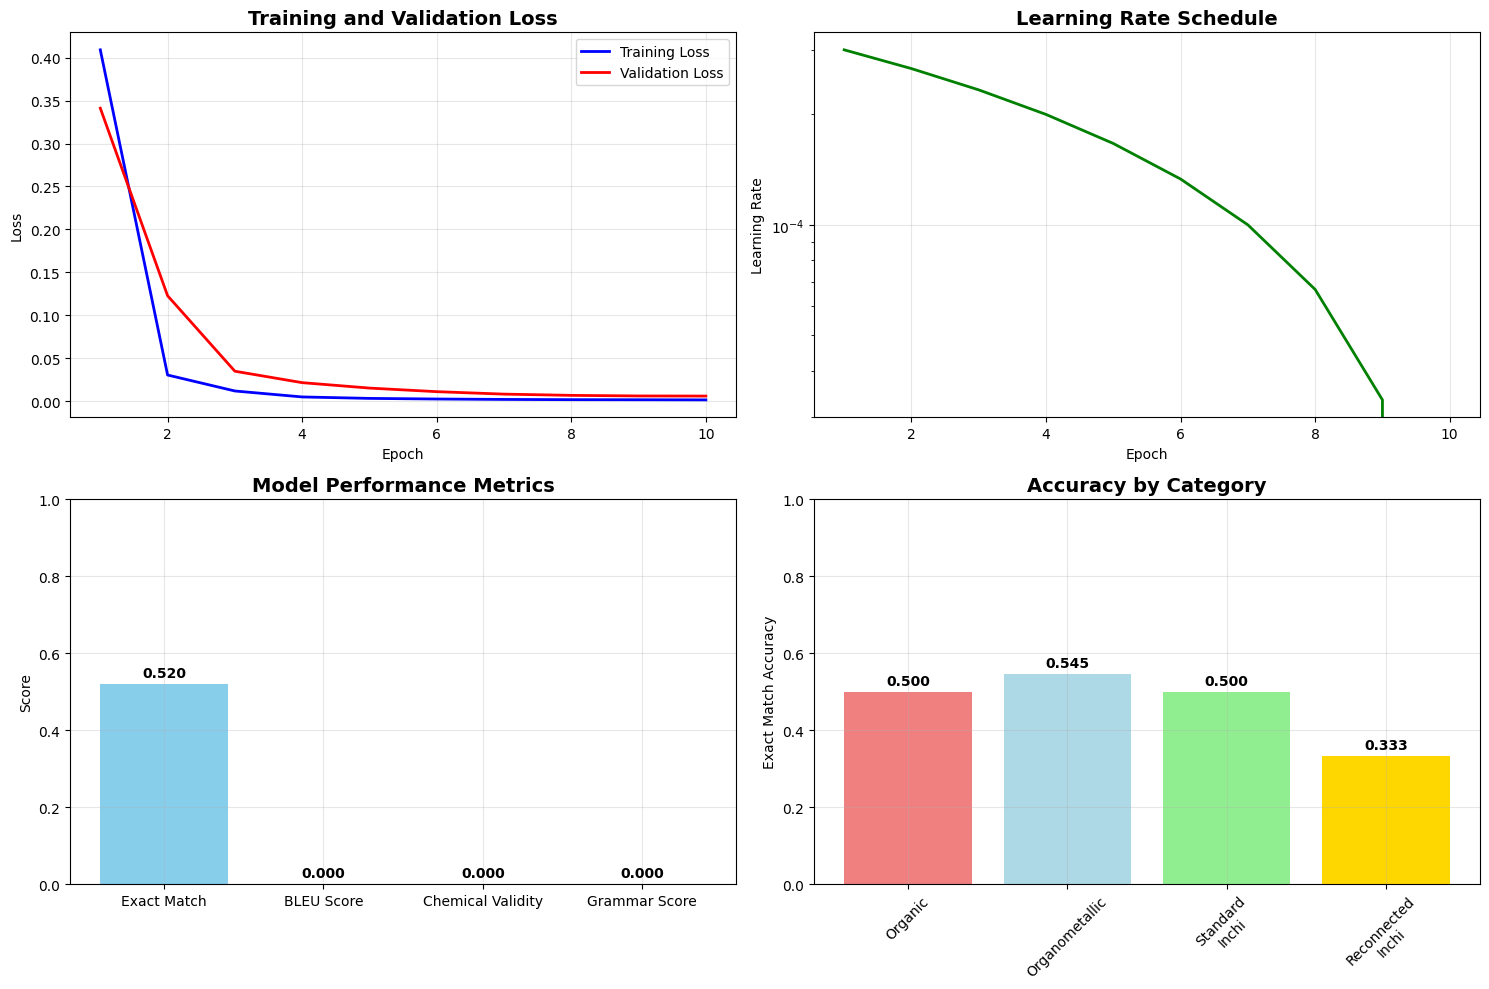


📋 DETAILED PREDICTION EXAMPLES
 ID                        True IUPAC                   Predicted IUPAC Match  BLEU Confidence Valid
  1                           benzene                           benzene     ✅ 0.178      0.920     ✅
  2                 α-D-glucopyranose                  -D-glucopyranose     ❌ 0.000      0.705     ✅
  3      bis(η⁵-cyclopentadienyl)iron bis( <extra_id_75> 5-cyclopent...     ❌ 0.000      0.605     ❌
  4      bis(2,2'-bipyridine)iron(II)      bis(2,2'-bipyridine)iron(II)     ✅ 0.178      0.512     ❌
  5           hexacarbonylchromium(0)                      benzoic acid     ❌ 0.000      0.530     ✅
  6      bis(2,2'-bipyridine)iron(II)      bis(2,2'-bipyridine)iron(II)     ✅ 0.178      0.512     ❌
  7            tetracarbonylcobalt(0)            tetracarbonylcobalt(0)     ✅ 0.178      0.495     ❌
  8                           toluene                      benzaldehyde     ❌ 0.000      0.890     ✅
  9 tetrakis(triphenylphosphine)ni... tetrakis(triphenylpho

In [ ]:
def plot_training_history(training_history):
    """Plot training and validation loss curves"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    epochs = range(1, len(training_history['train_loss']) + 1)

    # Training and validation loss
    ax1.plot(epochs, training_history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    if training_history['val_loss']:
        ax1.plot(epochs, training_history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Learning rate schedule
    ax2.plot(epochs, training_history['learning_rates'], 'g-', linewidth=2)
    ax2.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Learning Rate')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)

    # Model performance metrics
    metrics_names = ['Exact Match', 'BLEU Score', 'Chemical Validity', 'Grammar Score']
    metrics_values = [
        evaluation_results['metrics']['exact_match'],
        evaluation_results['metrics']['bleu_score'],
        evaluation_results['metrics']['chemical_validity'],
        evaluation_results['metrics']['grammar_score']
    ]

    bars = ax3.bar(metrics_names, metrics_values, color=['skyblue', 'lightgreen', 'orange', 'pink'])
    ax3.set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Score')
    ax3.set_ylim(0, 1)

    # Add value labels on bars
    for bar, value in zip(bars, metrics_values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.xticks(rotation=45)
    ax3.grid(True, alpha=0.3)

    # Performance by category
    categories = []
    accuracies = []

    for category, stats in evaluation_results['by_category'].items():
        if stats['count'] > 0:
            categories.append(category.replace('_', '\n').title())
            accuracies.append(stats['exact_match'])

    if categories:
        bars = ax4.bar(categories, accuracies, color=['lightcoral', 'lightblue', 'lightgreen', 'gold'])
        ax4.set_title('Accuracy by Category', fontsize=14, fontweight='bold')
        ax4.set_ylabel('Exact Match Accuracy')
        ax4.set_ylim(0, 1)

        # Add value labels
        for bar, value in zip(bars, accuracies):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

        plt.xticks(rotation=45)
        ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def create_prediction_examples_table(results):
    """Create a detailed table of prediction examples"""
    print("\n📋 DETAILED PREDICTION EXAMPLES")
    print("=" * 100)

    # Create DataFrame for better display
    examples_data = []

    for i, pred in enumerate(results['predictions'][:10]):
        examples_data.append({
            'ID': i + 1,
            'True IUPAC': pred['true_iupac'][:30] + '...' if len(pred['true_iupac']) > 30 else pred['true_iupac'],
            'Predicted IUPAC': pred['predicted_iupac'][:30] + '...' if len(pred['predicted_iupac']) > 30 else pred['predicted_iupac'],
            'Match': '✅' if pred['exact_match'] else '❌',
            'BLEU': f"{pred['bleu_score']:.3f}",
            'Confidence': f"{pred['validation']['confidence']:.3f}",
            'Valid': '✅' if pred['validation']['is_valid'] else '❌'
        })

    df = pd.DataFrame(examples_data)
    print(df.to_string(index=False))

# Generate visualizations
print("📊 Generating visualizations...")
plot_training_history(training_history)
create_prediction_examples_table(evaluation_results)